# Mapping

In [12]:
import time
import numpy as np
import BWT
from matplotlib import pyplot as plt
from importlib import reload
reload(BWT)

<module 'BWT' from 'c:\\Users\\csoub\\OneDrive\\Bureau\\3A\\Polytechnique\\INF589-Computational analysis of high-throughput sequencing data\\Index-structure-and-mapping\\BWT.py'>

In [3]:
### Test with sars_cov_2.txt:
seq = ''
with open("data/sars_cov_2.txt", 'r') as file:
    for line in file:
        seq += line.replace('\n', '')
print(len(seq))

N=1000
start=time.time()
my_BWT = BWT.BWT(seq[:N] + '$')
# print("Text sequence: ",my_BWT.text)
my_BWT.compute_sufixe_array()
print("suffix array done")
my_BWT.construct_bwt()
print("BTW done")
stop=time.time()
print("Time cumsumtion: {:.1f} sec".format(stop-start))
# print(my_BWT.L)

29903
suffix array done
BTW done
Time cumsumtion: 2.5 sec


In [4]:
x = "ATTA"
print(f"BWT search of {x} :")
occurences = my_BWT.bwt_search(x)
print(f"{x} figures {len(occurences) if occurences!= None else 0} times in the seq at positions : ")
try:
    for i in occurences: print(i[1],":	",i[0])
except:
    pass

BWT search of ATTA :
ATTA figures 4 times in the seq at positions : 
0 :	 ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTCGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGATTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACT

## Genome Mapping

In [5]:
read_length=100
read_sigma=50
fold_coverage=1
full_sequence=my_BWT.text

def create_reads(full_sequence,read_length=150,read_sigma=50,fold_coverage=5):
	reads_list=[]
	for i in range(fold_coverage):
		n=0
		while n<len(full_sequence):
			rand_int=int(np.random.normal(read_length,read_sigma))
			if n+rand_int<len(full_sequence):
				read=full_sequence[n:n+rand_int]
			else:
				read=full_sequence[n:]
			n+=rand_int
			reads_list.append(read)
	np.random.shuffle(reads_list)
	# reads_list=np.array(reads_list)
	return reads_list

reads=create_reads(full_sequence,read_length,read_sigma,fold_coverage)

In [6]:
for read in reads:
    occurences = my_BWT.bwt_search(read)
    print("#occurences: ",len(occurences)," position: ",str(occurences[0][1]))

#occurences:  1  position:  939
#occurences:  1  position:  710
#occurences:  1  position:  57
#occurences:  1  position:  363
#occurences:  1  position:  630
#occurences:  1  position:  471
#occurences:  1  position:  880
#occurences:  1  position:  0
#occurences:  1  position:  316
#occurences:  1  position:  756


In [38]:
def non_ambiguous_mapping(BWT,reads,len_sequence):
	association_table=[]
	reconstructed_seq=len_sequence*['*']
	flag=False
	for i,read in enumerate(reads):
		occurences = BWT.bwt_search(read)
		if len(occurences)>1:
			flag=True
			# print("Read with morethen 1 occurence")
		index=occurences[0][1]
		reconstructed_seq[index:index+len(read)]=list(read)
	return("".join(reconstructed_seq),flag)
  
start=time.time()
reconstructed_seq,ambiguity=non_ambiguous_mapping(my_BWT,reads,len(full_sequence))
stop=time.time()
print("Mapping time:",stop-start)
reconstructed_seq==full_sequence

Mapping time: 0.007993221282958984


False

## Time performences - count table

In [15]:
genome_size=np.linspace(500,2000,10)
read_length=np.linspace(10,400,40)
read_sigma=2
fold_coverage=1

time_cumsumption_BWT=np.zeros((3,len(genome_size)))
time_cumsumption_mapping=np.zeros( (len(genome_size),len(read_length)))
ambiguities=np.zeros( (len(genome_size),len(read_length)))
reconstructions=np.zeros( (len(genome_size),len(read_length)))

for i,N in enumerate(genome_size):
    N=int(N)
    start=time.time()
    my_BWT = BWT.BWT(seq[:N] + '$')
    stop_init=time.time()
    my_BWT.compute_sufixe_array()
    stop_suffix=time.time()
    my_BWT.construct_bwt()
    stop=time.time()
    time_cumsumption_BWT[0,i]=stop_init-start
    time_cumsumption_BWT[1,i]=stop_suffix-stop_init
    time_cumsumption_BWT[2,i]=stop-stop_suffix
    for j,K in enumerate(read_length):
        K=int(K)
        reads=create_reads(my_BWT.text,K,read_sigma,fold_coverage)
        start=time.time()
        reconstructed_seq,ambiguity=non_ambiguous_mapping(my_BWT,reads,len(my_BWT.text))
        stop=time.time()
        time_cumsumption_mapping[i,j]=stop-start
        ambiguities[i,j]=ambiguity
        reconstructions[i,j]=(reconstructed_seq==my_BWT.text)
    print(str(i+1),"/",len(genome_size))
        
        

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


[]

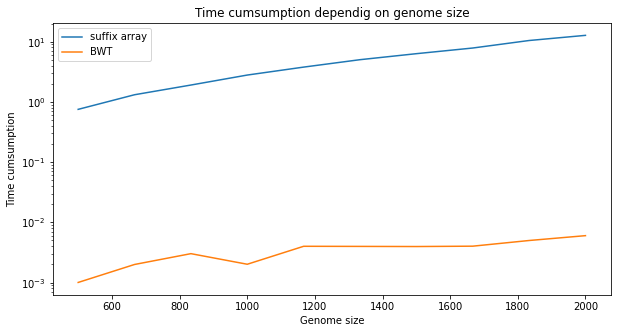

In [43]:
# plt.plot(genome_size,time_cumsumption_BWT[0,:],label='init')
plt.figure(figsize=(10,5))
plt.title("Time cumsumption dependig on genome size")
plt.plot(genome_size,time_cumsumption_BWT[1,:],label='Suffix array creation')
plt.plot(genome_size,time_cumsumption_BWT[2,:],label='BWT computation')
plt.xlabel("Genome size")
plt.ylabel("Time cumsumption")
plt.legend()
plt.yscale("log")
plt.plot()

Text(0.5, 1.0, 'Time cumsumption in ms')

<Figure size 1440x360 with 0 Axes>

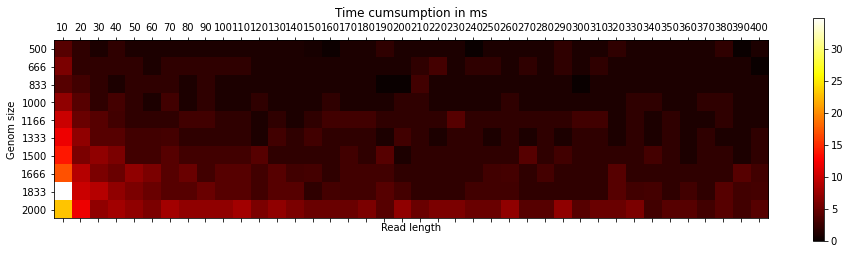

In [41]:
plt.figure(figsize=(20,5))
plt.matshow(time_cumsumption_mapping*1000,cmap='hot')
plt.xticks(np.arange(0,len(read_length)),labels=(int(s) for s in read_length))
plt.xlabel("Read length")
plt.yticks(np.arange(0,len(genome_size)),labels=(int(s) for s in genome_size))
plt.ylabel("Genom size")
plt.colorbar()
plt.title("Time cumsumption in ms")